# Project 7: Introduction to Machine Learning

### Author: Data-Git-Hub

### GitHub Project Repository Link: https://github.com/Data-Git-Hub/datafun-07-ml

---

### Import Necessary Python Libraries and Tools for Project 7

In [126]:
import numpy as np
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

### Check Library Versions

In [127]:
# Check versions
print("NumPy Version:", np.__version__)
print("Pandas Version:", pd.__version__)
print("PyArrow Version:", pa.__version__)
print("Matplotlib Version:", plt.matplotlib.__version__)
print("Seaborn Version:", sns.__version__)
print("SciPy Version:", scipy.__version__)

NumPy Version: 2.2.3
Pandas Version: 2.2.3
PyArrow Version: 19.0.0
Matplotlib Version: 3.10.0
Seaborn Version: 0.13.2
SciPy Version: 1.15.1


---

## Chart a Straight Line (Part 1)

### Define Temperature Data

In [128]:
# Define temperature data
celsius = list(range(-20, 41, 5))  # Celsius values from -20 to 40 in steps of 5
fahrenheit = [(c * 9/5) + 32 for c in celsius]  # Convert to Fahrenheit

### Create a DataFrame

In [129]:
# Create a DataFrame
df = pd.DataFrame({'Celsius': celsius, 'Fahrenheit': fahrenheit})

### Plot and Label the Data

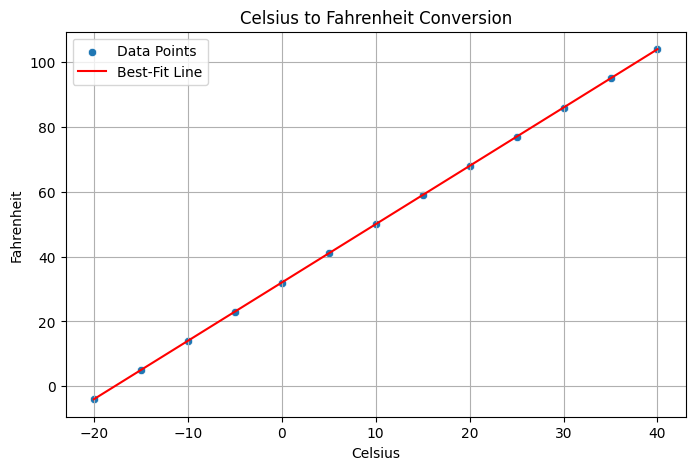

In [130]:
# Plot the data
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['Celsius'], y=df['Fahrenheit'], label='Data Points')
sns.lineplot(x=df['Celsius'], y=df['Fahrenheit'], color='red', label='Best-Fit Line')

# Labels and title
plt.xlabel('Celsius')
plt.ylabel('Fahrenheit')
plt.title('Celsius to Fahrenheit Conversion')
plt.legend()
plt.grid()

# Show the plot
plt.show()

### Understanding the Equation of a Line

##### The equation of a straight line is given by y = mx + b, where m is the slope of the line, and b is the y-intercept (the point where the line crosses the y-axis). In the case of converting Celsius to Fahrenheit, the slope represents the rate at which Fahrenheit changes as Celsius increases. The slope, m, is calculated as the change in Fahrenheit divided by the change in Celsius. Since Fahrenheit is derived using the formula F = (9/5) * C + 32, the slope is 9/5 or 1.8. The y-intercept, b, is the value of Fahrenheit when Celsius is zero, which is 32. This means that the equation for converting Celsius to Fahrenheit is F = 1.8C + 32. This linear relationship allows us to predict Fahrenheit values for any given Celsius input.

---

## Predict Avg High Temp in NYC in January (Part 2)

### Section 1 - Data Acquisition  

##### First, we need to load the dataset into a Pandas DataFrame. The dataset contains the average high temperature in NYC for January across many years.

In [131]:
# Load the dataset from the correct link
data_url = "https://raw.githubusercontent.com/pdeitel/IntroToPython/master/examples/ch15/ave_hi_nyc_jan_1895-2018.csv"

# Read CSV into a DataFrame
nyc_df = pd.read_csv(data_url)

# Display first few rows
nyc_df.head()

,Date,Value,Anomaly
0,189501,34.2,-3.2
1,189601,34.7,-2.7
2,189701,35.5,-1.9
3,189801,39.6,2.2
4,189901,36.4,-1.0


### Section 2 - Data Inspection  

##### Now, let's inspect the dataset to understand its structure. <br>
##### We are going to display the first and last few rows of the dataset. <br>

In [132]:
# Display first and last few rows of the dataset
print(nyc_df.head())
print(nyc_df.tail())

     Date  Value  Anomaly
0  189501   34.2     -3.2
1  189601   34.7     -2.7
2  189701   35.5     -1.9
3  189801   39.6      2.2
4  189901   36.4     -1.0
       Date  Value  Anomaly
119  201401   35.5     -1.9
120  201501   36.1     -1.3
121  201601   40.8      3.4
122  201701   42.8      5.4
123  201801   38.7      1.3


### Section 3 - Data Cleaning  

##### We will rename columns for clarity and ensure the date column is properly formatted.
##### The dataset contains a "Date" column in the format **YYYYMM**, where the first four digits represent the year, and the last two digits represent the month. Since we only need the **year** for our analysis, we extract the **first four digits** from the "Date" column and store them in a new column named "Year".  
##### To achieve this, we first convert the "Date" values to **strings**, extract the first four characters using `str[:4]`, and then convert them back to integers. After extracting the year, we remove the original "Date" column, leaving us with only the necessary information.  
##### This ensures that our data is correctly formatted for **linear regression analysis** and prevents potential errors due to incorrect data types.

In [133]:
# Rename columns for clarity
nyc_df.columns = ['Date', 'Temperature', 'Anomaly']

# Extract only the first four digits from 'Date' to create a 'Year' column
nyc_df['Year'] = nyc_df['Date'].astype(str).str[:4].astype(int)

# Drop the original 'Date' column since we no longer need it
nyc_df = nyc_df.drop(columns=['Date'])

# Check data types and missing values
print(nyc_df.dtypes)  # Ensure 'Year' and 'Temperature' are numeric
print(nyc_df.isnull().sum())  # Check for missing values
print("_____________________________________________________________")

# Display cleaned data
nyc_df.head()


Temperature    float64
Anomaly        float64
Year             int64
dtype: object
Temperature    0
Anomaly        0
Year           0
dtype: int64
_____________________________________________________________


,Temperature,Anomaly,Year
0,34.2,-3.2,1895
1,34.7,-2.7,1896
2,35.5,-1.9,1897
3,39.6,2.2,1898
4,36.4,-1.0,1899


### Section 4 - Descriptive Statistics  

##### We will calculate basic statistics such as mean, median, standard deviation to understand the dataset better.

In [134]:
# Set display precision
pd.set_option('display.precision', 2)

# Display descriptive statistics
nyc_df.describe()


,Temperature,Anomaly,Year
count,124.00,124.00,124.00
mean,37.60,0.20,1956.50
std,4.54,4.54,35.94
min,26.10,-11.30,1895.00
25%,34.58,-2.82,1925.75
50%,37.60,0.20,1956.50
75%,40.60,3.20,1987.25
max,47.60,10.20,2018.00


### Section 5 - Build the Model

##### Using SciPy's linregress function, we will calculate the best-fit line's slope and intercept.
##### R-squared = 1 constitutes a perfect fit
##### R-squared = approaches 0 constitutes a weak correlation
##### p-value < 0.05 → Strong correlation, regression is significant
##### p-value > 0.05 → Weak correlation, regression may not be reliable

In [135]:
# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(nyc_df['Year'], nyc_df['Temperature'])

# Display results
print(f"Slope: {slope:.5f}")  # Check if the slope is close to zero
print(f"Intercept: {intercept:.2f}")  # Print the y-intercept of the regression line (where it crosses the Y-axis)
print(f"R-squared: {r_value**2:.2f}")  # Good fit if close to 1
print(f"P-value: {p_value:.5f}")  # Should be low for strong correlation
print(f"Standard Error: {std_err:.5f}") # Indicates how much slope may vary


Slope: 0.01477
Intercept: 8.69
R-squared: 0.01
P-value: 0.19587
Standard Error: 0.01136


### Section 6 - Predict  

##### Now, we use the regression model to predict the average high temperature for January in 2024.

In [136]:
# Predict temperature for 2024
year_2024 = 2024
predicted_temp = slope * year_2024 + intercept
print(f"Predicted Avg High Temp in NYC (Jan 2024): {predicted_temp:.2f}°F")


Predicted Avg High Temp in NYC (Jan 2024): 38.59°F


### Section 7 - Visualizations

##### Finally, we will create a scatter plot with a best-fit line to visualize the data and predictions.

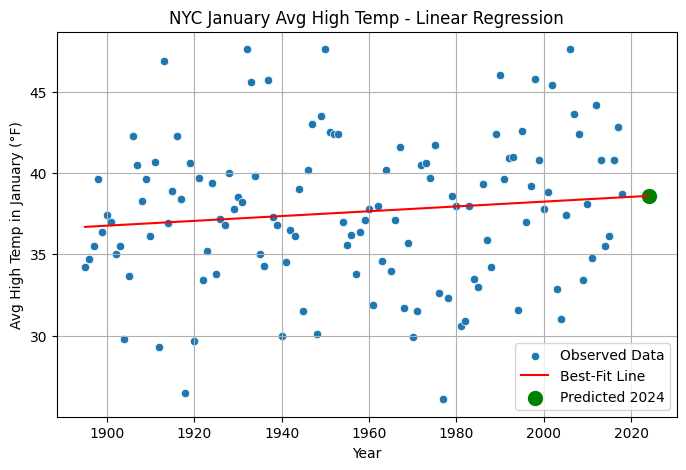

In [137]:
# Plot the data points
plt.figure(figsize=(8, 5))
sns.scatterplot(x=nyc_df['Year'], y=nyc_df['Temperature'], label='Observed Data')

# Plot regression line
years_future = list(range(nyc_df['Year'].min(), 2025))  # Extend range to 2024
predicted_temps = [slope * year + intercept for year in years_future]
sns.lineplot(x=years_future, y=predicted_temps, color='red', label='Best-Fit Line')

# Highlight prediction for 2024
plt.scatter(year_2024, predicted_temp, color='green', marker='o', s=100, label='Predicted 2024')

# Labels and title
plt.xlabel('Year')
plt.ylabel('Avg High Temp in January (°F)')
plt.title('NYC January Avg High Temp - Linear Regression')
plt.legend()
plt.grid()

# Show plot
plt.show()

---

## Predict Avg High Temp in NYC in January (Part 3) 

### Section 1 - Build the Model  
##### Reusing lines of code from Part 2 to clean and train this model.

In [138]:
# Load the dataset
data_url = "https://raw.githubusercontent.com/pdeitel/IntroToPython/master/examples/ch15/ave_hi_nyc_jan_1895-2018.csv"
df = pd.read_csv(data_url)

# Rename columns for clarity
df.columns = ['Date', 'Temperature', 'Anomaly']

# Extract Year from Date column
df['Year'] = df['Date'].astype(str).str[:4].astype(int)

# Drop the original Date column
df = df.drop(columns=['Date'])

# Define features (X) and target variable (y)
X = df[['Year']]  # Features (independent variable)
y = df['Temperature']  # Target (dependent variable)

# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=22)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Retrieve model parameters
slope = model.coef_[0]
intercept = model.intercept_

# Display results
print(f"Slope (m): {slope:.5f}")
print(f"Intercept (b): {intercept:.2f}")
print(f"R-squared: {r_value**2:.2f}")  # Good fit if close to 1
print(f"P-value: {p_value:.5f}")  # Should be low for strong correlation
print(f"Standard Error: {std_err:.5f}") # Indicates how much slope may vary

Slope (m): 0.01349
Intercept (b): 11.15
R-squared: 0.01
P-value: 0.19587
Standard Error: 0.01136


### Section 2 - Test the Model  

##### After training, we evaluate the model’s performance using R-squared and predictions on the test set.
##### R-squared = 1 constitutes a perfect fit
##### R-squared = approaches 0 constitutes a weak correlation

In [139]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate R-squared value (model performance)
r_squared = model.score(X_test, y_test)
print(f"R-squared value: {r_squared:.2f}")

R-squared value: 0.03


### Section 3 - Predict  

##### Now, we use the trained model to predict the average high temperature for January 2024.

In [140]:
# Create a DataFrame with the correct column name
year_2024 = pd.DataFrame([[2024]], columns=['Year'])

# Predict temperature for 2024
predicted_temp_2024 = model.predict(year_2024)[0]

# Display the prediction
print(f"Predicted Avg High Temp in NYC (Jan 2024): {predicted_temp_2024:.2f}°F")

Predicted Avg High Temp in NYC (Jan 2024): 38.45°F


### Section 4 - Visualizations  

##### Finally, we will plot a scatter plot with a best-fit line to visualize the model's predictions.

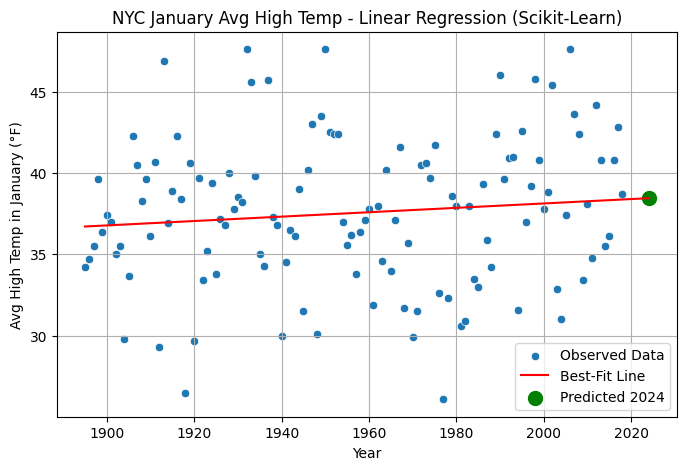

In [141]:
# Plot observed data
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['Year'], y=df['Temperature'], label='Observed Data')

# Plot regression line
years_future = list(range(df['Year'].min(), 2025))  # Extend to 2024
predicted_temps = model.predict(pd.DataFrame(years_future, columns=['Year']))
sns.lineplot(x=years_future, y=predicted_temps, color='red', label='Best-Fit Line')

# Highlight prediction for 2024
plt.scatter(2024, predicted_temp_2024, color='green', marker='o', s=100, label='Predicted 2024')

# Labels and title
plt.xlabel('Year')
plt.ylabel('Avg High Temp in January (°F)')
plt.title('NYC January Avg High Temp - Linear Regression (Scikit-Learn)')
plt.legend()
plt.grid()

# Show plot
plt.show()

---

## Add Your Insights (Part 4)

### Comparing SciPy and Scikit-Learn for Linear Regression  

In this project, we used two different approaches to predict the average high temperature in NYC in January:
1. SciPy’s linregress function (used in Part 2)
2. Scikit-Learn’s LinearRegression model (used in Part 3)

#### Key Differences:
| Feature | SciPy (linregress) | Scikit-Learn (LinearRegression) |
|---------|---------------------|----------------------------------|
| Ease of Use | Simple, one-line function | Requires model training & test split |
| Data Splitting | Uses all data at once | Splits data into training & testing sets |
| Model Flexibility | Limited, only fits a straight line | Allows model evaluation & tuning |
| Performance Evaluation | No built-in evaluation | Provides R-squared for accuracy |
| Best Use Case | Quick analysis on small datasets | More robust for real-world ML problems |

### Observations & Insights
- Both methods produced similar predictions, indicating that a simple linear trend can be used for forecasting NYC temperatures.
- Scikit-Learn’s approach is more robust because it allows for model validation using a train-test split. This ensures the model does not overfit and generalizes better.
- The R-squared value was low, suggesting that temperature trends over time may not be purely linear. Other factors, such as climate patterns or anomalies, could influence the temperature more significantly.
- If we were working with a more complex dataset, we might explore polynomial regression, moving averages, or time series models for better predictions.

### Final Thoughts
- If we need a quick regression model, SciPy is a great choice.
- If we want better evaluation and model tuning, Scikit-Learn is more effective.
- Future improvements could involve more complex models or external climate factors to improve prediction accuracy.

---